In [1]:
import os
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
from PIL import Image as im
from PIL import Image
import shutil
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
from sklearn import linear_model
import torch

torch.manual_seed(42)

In [2]:
#Create a table, 
#where each row contains information [match# with img1] [match# with img2] [match# with img384] [Class Name of this row]
path = 'Experiment2/MatchNumbersTable.npz'
number_of_matches_between_every_image = np.load(path)['arr_0']
TotalImage=number_of_matches_between_every_image.shape[0]

path = 'Experiment2/2D_list_of_all_npzs_with_class.npz'
name_of_npzfile_between_each_pair_with_className_of_rowImg = np.load(path)['arr_0']
class_name_of_each_rowImg=name_of_npzfile_between_each_pair_with_className_of_rowImg[:,TotalImage]

class_names=list(set(class_name_of_each_rowImg))
class_name_of_each_rowImg=np.reshape(class_name_of_each_rowImg,(TotalImage,1))
number_of_matches_between_every_image_with_className=np.append(number_of_matches_between_every_image,class_name_of_each_rowImg,1)



For every image, take k top #of matches for every class.

In [9]:
def create_dataset_wrt_k(k_given,percentage,number_of_matches_between_every_image_with_className,class_names,class_name_of_each_rowImg):
    
    k=k_given
    X=[]
    Y=[]
    TotalImage=number_of_matches_between_every_image_with_className.shape[0]

    for mainImgNumber in range(TotalImage):
        x=[]
        for currentClassName in class_names:
            number_of_matches_per_class=[]

            for i in range(TotalImage):
                if i!= mainImgNumber and class_name_of_each_rowImg[i]==currentClassName:
                    number_of_matches_per_class.append(number_of_matches_between_every_image_with_className[mainImgNumber,i])

            number_of_matches_per_class=np.reshape(number_of_matches_per_class,(1,len(number_of_matches_per_class)))
            number_of_matches_per_class=number_of_matches_per_class.astype(np.float64)
            number_of_matches_per_class.sort(axis=1)
            
            if k>number_of_matches_per_class.shape[1]:
                k=len(number_of_matches_per_class)
            else:
                k=k_given
                
            if percentage==True:
                k=math.ceil(len(number_of_matches_per_class)*(k_given/100))
                    
            average_match_wrt_k=np.sum(number_of_matches_per_class[0][-k:])/k
            x.append(average_match_wrt_k)
            
        X.append(x)
        Y.append(number_of_matches_between_every_image_with_className[mainImgNumber,TotalImage])
    X=np.reshape(X,(TotalImage,len(class_names)))
    Y=np.reshape(Y,(TotalImage,1))
    #X=np.reshape(X,(1,len(class_names)))
    #for cn in range(len(class_names)):
        #print(class_names[cn]," = ",X[0][cn])
    #print(Y)
    
    return X,Y

In [10]:
#print(number_of_matches_between_every_image_with_className[0])
[X,Y]=create_dataset_wrt_k(2,False,number_of_matches_between_every_image_with_className,class_names,class_name_of_each_rowImg)


Misclassified # =  [0, 2, 0, 3, 3, 0, 2, 2, 1, 6, 0, 3, 4, 0, 6, 0, 0, 3, 0, 1, 3, 0, 1, 1, 0, 0, 7]
# of image per class =  [3, 2, 50, 3, 10, 10, 2, 2, 7, 10, 60, 3, 12, 22, 6, 4, 10, 6, 34, 43, 11, 23, 7, 3, 19, 8, 14]


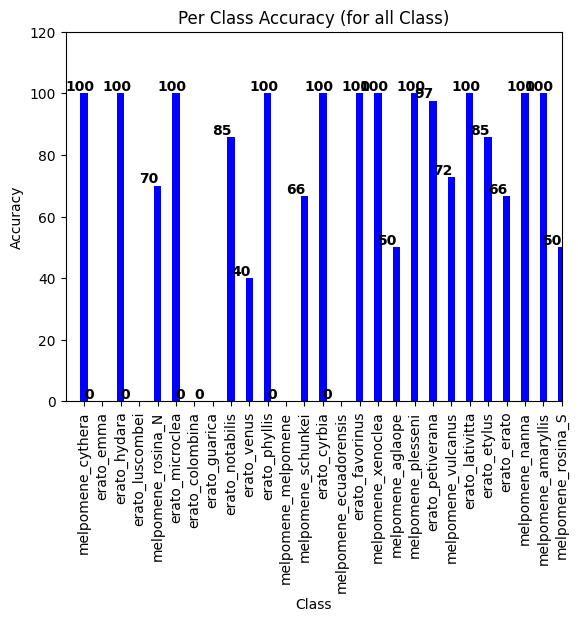

Weighted Avg Accuracy=  66.11717022569735
Accuracy = 87.5


In [84]:
accuracy=0

misclassification_per_class=[0]*27
weighted_error=[]
number_of_image_per_class=[0]*27
x_num=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]

for i in range(X.shape[0]):
    all_matches_per_image=X[i,:]
    max_pos=np.where(all_matches_per_image==all_matches_per_image.max())[0][0]
    current_image_pos=class_names.index(Y[i][0])
    
    number_of_image_per_class[current_image_pos]+=1
    
    if Y[i][0] == class_names[max_pos]:
        accuracy=accuracy+1
    else:
        misclassification_per_class[current_image_pos]+=1
        #print(Y[i][0]," prediction:= ", class_names[max_pos] )
        
print("Misclassified # = ",misclassification_per_class)
print("# of image per class = ",number_of_image_per_class)

#weighted_error=[(i / j)*100 for i, j in zip(misclassification_per_class, number_of_image_per_class)]
#plot_misclassification(x_num,class_names,misclassification_per_class,"misclassification number per class for all","Image Number","class")

#print("Weighted Error=",weighted_error)
#plot_misclassification(x_num,class_names,weighted_error,"weighted error per class for all","Weighted Error","Class")


weighted_accuracy=[((j-i) / j)*100 for i, j in zip(misclassification_per_class, number_of_image_per_class)]
plot_misclassification(number_of_image_per_class,x_num,class_names,weighted_accuracy,\
                       "Per Class Accuracy (for all Class)","Accuracy","Class")

weighted_avg_accuracy=np.sum(weighted_accuracy)/len(class_names)


print("Weighted Avg Accuracy= ",weighted_avg_accuracy)

print("Accuracy =",(accuracy/384)*100)


In [71]:
#N nearest for mimic pairs
import csv

all_accuracy=[]
mimic_pairs=12

misclassification_per_class_all_pairs=[]
Weighted_Error_for_all_mimic_pair=[]
Weighted_Accuracy_for_all_mimic_pair=[]
all_labels=[]

with open ('mimic_pairs.csv') as csv_file:
    csv_reader=csv.reader(csv_file,delimiter=",")
    for row in csv_reader:
        print(row[0],row[1])
        
        for i in range(len(class_names)):
            if class_names[i]== row[0]:
                row_0_pos=i
            elif class_names[i]== row[1]:
                row_1_pos=i
                
        #print(row[0]," pos= ",row_0_pos,"...",row[1]," pos= ",row_1_pos)        
        count=0
        accuracy=0
        n_img0=0
        n_img1=0
        misclassification_per_class=[0]*2
        
        for i in range(X.shape[0]):
            if Y[i][0]==row[0] or Y[i][0]== row[1]:
                count+=1

                just_mimic_matches_for_this_image=X[i,[row_0_pos,row_1_pos]]
                #print(just_mimic_matches_for_this_image)
                
                if just_mimic_matches_for_this_image[0]>just_mimic_matches_for_this_image[1] and\
                Y[i][0]==row[0]:
                    accuracy=accuracy+1
                    n_img0+=1
                    
                elif just_mimic_matches_for_this_image[0]<just_mimic_matches_for_this_image[1] and\
                Y[i][0]==row[1]:
                    accuracy=accuracy+1
                    n_img1+=1
                    
                else:
                    if Y[i][0] == row[0]:
                        misclassification_per_class[0]+=1
                        n_img0+=1
                    else:
                        misclassification_per_class[1]+=1
                        n_img1+=1
                        
        print("Number of Images= ",n_img0,n_img1,count)
        
        weighted_error=[(misclassification_per_class[0]/n_img0)*100,(misclassification_per_class[1]/n_img1)*100]
        weighted_accuracy=[((n_img0-misclassification_per_class[0])/n_img0)*100,\
                        ((n_img1-misclassification_per_class[1])/n_img1)*100]

        
        
        Weighted_Accuracy_for_all_mimic_pair.extend(weighted_accuracy)
        
        if accuracy/count != 1:
            #plot_misclassification([0,1],[row[0],row[1]],misclassification_per_class,"Number of Misclassification for mimic pair"\
            #,"# of Images","class name")
             
            #plot_misclassification([0,1],[row[0],row[1]],weighted_error,"Weighted Error for mimic pair= (misclassified img/ # of img)*100"\
            #,"Weighted Error","class name")
            
            misclassification_per_class_all_pairs.extend(misclassification_per_class)
            Weighted_Error_for_all_mimic_pair.extend(weighted_error)
            all_labels.extend([row[0]+".vs.",row[1]])
        else:
            misclassification_per_class_all_pairs.extend(misclassification_per_class)
            Weighted_Error_for_all_mimic_pair.extend(weighted_error)
            all_labels.extend([row[0]+".vs.",row[1]])
            
        
        #print("Accuracy =",(accuracy/count)*100)
        all_accuracy.append(accuracy/count)

x_num=[]
for i in range(len(all_labels)):
    x_num.append(i)
    
#plot_misclassification(x_num,all_labels,Weighted_Error_for_all_mimic_pair,"Weighted Misclassified Error For Mimic Pair","percentage","class")
print(Weighted_Accuracy_for_all_mimic_pair)
plot_misclassification(x_num,all_labels,Weighted_Accuracy_for_all_mimic_pair,"Weighted Accuracy For Mimic Pair","percentage","class")

print("Average Accuracy: ",(sum(all_accuracy)/mimic_pairs)*100)
weight_avg_accuracy=np.sum(Weighted_Accuracy_for_all_mimic_pair)/len(Weighted_Accuracy_for_all_mimic_pair)
print("Weighted Avg Accuracy: ",weight_avg_accuracy)
print(len(Weighted_Accuracy_for_all_mimic_pair))
        
    
    
    
    
    

erato_petiverana melpomene_rosina_N
Number of Images=  43 10 53
erato_petiverana melpomene_rosina_S
Number of Images=  43 14 57
erato_hydara melpomene_melpomene
Number of Images=  50 3 53
erato_venus melpomene_vulcanus
Number of Images=  10 11 21
erato_cyrbia melpomene_cythera
Number of Images=  22 3 25
erato_notabilis melpomene_plesseni
Number of Images=  7 34 41
erato_etylus melpomene_ecuadorensis
Number of Images=  7 6 13
erato_emma melpomene_aglaope
Number of Images=  2 6 8
erato_favorinus melpomene_amaryllis
Number of Images=  4 8 12
erato_microclea melpomene_xenoclea
Number of Images=  10 10 20
erato_luscombei melpomene_schunkei
Number of Images=  3 12 15
erato_phyllis melpomene_nanna
Number of Images=  60 19 79
[100.0, 100.0, 100.0, 100.0, 100.0, 0.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


TypeError: plot_misclassification() missing 1 required positional argument: 'x_label'

In [83]:
def plot_misclassification(n_of_img,x_axis_num,x_labels,class_wise_misclassification,title,y_label, x_label):
    plt.axis([0,len(x_axis_num), 0, max(class_wise_misclassification)+1])
    plt.bar(x_axis_num, class_wise_misclassification, color ='blue',width = 0.4)
    for i, v in enumerate(class_wise_misclassification):
        if i==16:
            plt.text(i, v+1, str(int(v)), color='black', fontweight='bold',rotation=0)
        else:
            plt.text(i, v+1, str(int(v)), color='black', fontweight='bold',rotation=0)
    #plt.plot(x_num,n_of_img,'go--', linewidth=2, markersize=12)
    plt.xticks(x_axis_num, x_labels, rotation=90)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.ylim(top = 120)
    plt.title(title)
    plt.show()

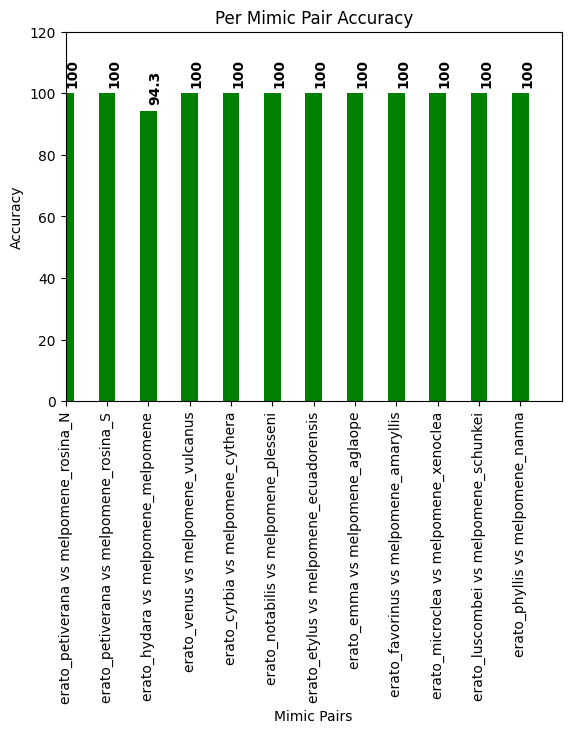

In [69]:
x_num=[]
Weighted_Accuracy_for_all_mimic_pair=[]
all_labels=[]
with open ('mimic_pairs.csv') as csv_file:
    csv_reader=csv.reader(csv_file,delimiter=",")
    for row in csv_reader:
        all_labels.append(row[0]+" vs "+row[1])
        
for i in range(12):
    x_num.append(i)
    if i!=2:
        Weighted_Accuracy_for_all_mimic_pair.append(100)
    else:
        Weighted_Accuracy_for_all_mimic_pair.append(94.3)
plot_misclassification(x_num,all_labels,Weighted_Accuracy_for_all_mimic_pair,"Per Mimic Pair Accuracy","Accuracy","Mimic Pairs")


In [31]:
def plot_misclassification_y(x_axis_num,x_labels,class_wise_misclassification,title,y_label, x_label):
    plt.axis([0, max(class_wise_misclassification)+1,0,len(x_axis_num)])
    plt.bar(class_wise_misclassification, x_axis_num, color ='blue',width = 0.4)
    plt.plot(x_num,n_of_img,'go--', linewidth=2, markersize=12)
    plt.yticks(x_axis_num, x_labels, rotation=45)
    plt.xlabel(y_label)
    plt.ylabel(x_label)
    plt.title(title)
    plt.show()